### Create an algorithm to automate nucleus detection



In [2]:
! kaggle competitions download -c data-science-bowl-2018

  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 38.2MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 55.4MB/s]
 99% 9.00M/9.10M [00:00<00:00, 33.8MB/s]
100% 9.10M/9.10M [00:00<00:00, 35.2MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 4.05MB/s]
 94% 74.0M/79.1M [00:01<00:00, 80.8MB/s]
100% 79.1M/79.1M [00:01<00:00, 76.8MB/s]
100% 275M/276M [00:02<00:00, 112MB/s]
100% 276M/276M [00:02<00:00, 109MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 125MB/s]


In [4]:
import pathlib
import imageio
import numpy as np

In [12]:
!mkdir stage1_train

import zipfile

try:
    with zipfile.ZipFile("../content/stage1_train.zip") as zf:
        zf.extractall("../content/stage1_train")
        print("uncompress success")
        zf.close()

except:
    print("uncompress fail")

uncompress success


In [14]:
training_paths = pathlib.Path('../content/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]
im = imageio.imread(str(im_path))

### coerce all the images into grayscale

(RGB, RGBA, grayscale to grayscale)

In [16]:
print('original image shape : {}'.format(im.shape))

from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('new iamge shape : {}'.format(im_gray.shape))

original image shape : (520, 696, 4)
new iamge shape : (520, 696)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  after removing the cwd from sys.path.


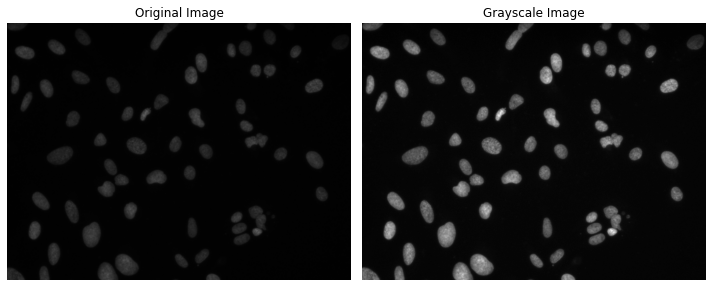

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

### Remove background

Bimodal distribution of intensities : find the best separation value

: use Otsu method (model the image as a bimodal distribution & find the optimal separation value)

In [20]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

if np.sum(mask==0) < np.sum(mask==1):
  mask = np.where(mask, 0, 1)

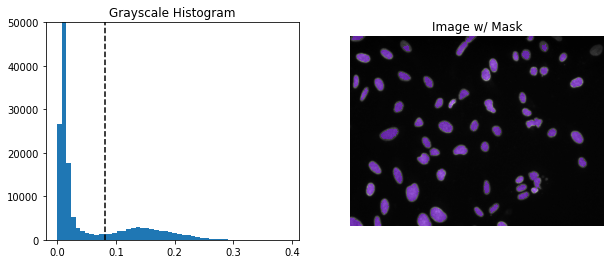

In [21]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

### Individual masks for each object

We need to get a separate mask for each nucleus : look for all objects in the mask that are connected.

Assign each of them a number using ndimage.label

In [22]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for n in range(1, nlabels+1):
  label_mask = np.where(labels == n, 1, 0)
  label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


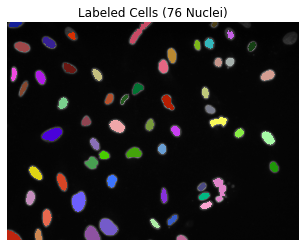

In [23]:
# Create a random colormap
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

### Get list of range for each labeled object

In [24]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # Check if the label size is too small
    if np.product(cell.shape) < 10: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

# Regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 separate components / objects detected.


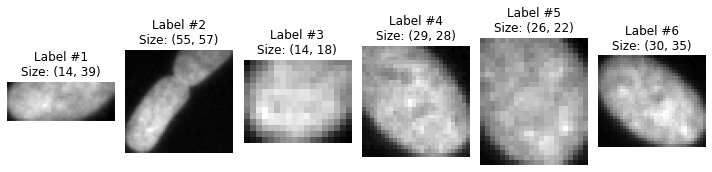

In [25]:
fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

In [26]:
# Get the object indices, and perform a binary opening procedure
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

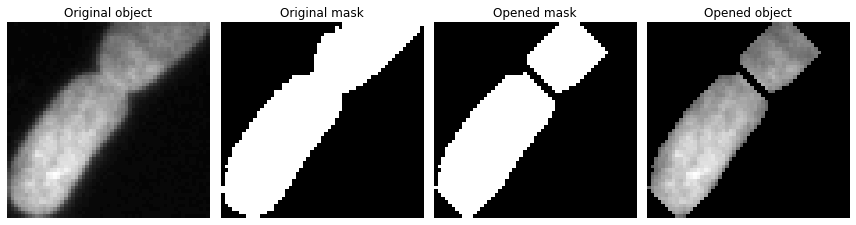

In [27]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

### Run Line Encoding

In [28]:
def rle_encoding(x):
    
    # x: numpy array of shape (height, width), 1 - mask, 0 - background
    # Returns run length as list

    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


### combine into a single function

In [30]:
import pandas as pd

def analyze_image(im_path):
  # image grayscale로
  im_id = im_path.parts[-3]
  im = imageio.imread(str(im_path))
  im_gray = rgb2gray(im)

  # background mask out, 연결된 object 추출
  thresh_val = threshold_otsu(im_gray)
  mask = np.where(im_gray > thresh_val, 1, 0)
  if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)
    labels, nlabels = ndimage.label(mask)

  # to DataFrame
  im_df = pd.DataFrame()
  for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
  return im_df

In [31]:
def analyze_list(im_path_list):
  all_df = pd.DataFrame()
  for im_path in im_path_list:
    im_df = analyze_image(im_path)
    all_df = all_df.append(im_df, ignore_index = True)
  
  return all_df